In [1]:
import calendar
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from scipy.stats import ttest_ind, linregress
import seaborn as sns
import shap
from sklearn.cluster import KMeans
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
import xgboost
from xgboost import XGBRegressor, plot_importance

import warnings
warnings.filterwarnings('ignore') 

/root/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### *The* bike sharing dataset.

(yeah baby)

Having done mostly simple ML projects lately, I thought i'd brush-up on some DS skills.  So as more of a personal note, this is one of those projects where variables don't operate alone.  Ergo: The best time for renting a bike could be 2pm, but the day, month and season (plus possibly a host of other variables) will likely have to be factored-in, making this the type of project which isn't simply a "cut through the noise and find data points ML project" and there will be some complex(ish) relationships in the data.  For that reason I will use XGBoost for the final model.  This kills two birds with one stone because I will want to use SHAP analysis at the end of the project, and XGB likes SHAP (or vice-versa).  There is no introduction, this is a basic dataset downloaded from one of the usual data repos so there was no need to build a dataframe or scrape the webz, I am simply on holiday and wanted some BI action.

### Let's be lazy...

And, in case anyone out there doesn't already know, i'll ask AI why XGB works better for this type of data as opposed to my usual weapon of choice, LightGBM:

XGBoost is often considered favorable for datasets with complex relationships and interactions between features because of the following key reasons:

1. **Robust Handling of Nonlinear Relationships**: XGBoost relies on boosting decision trees, which are inherently good at capturing nonlinear interactions between features. This makes XGBoost highly effective for datasets like yours where relationships (e.g., time, day, weather, etc.) are not simply linear but hierarchical or interdependent.

2. **Built-in Regularization**: XGBoost incorporates L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting. This can make it more robust to noise in a complex dataset compared to LightGBM.

3. **Feature Importances & Explainers**: XGBoost is particularly compatible with SHAP (SHapley Additive exPlanations), making it easier to explain the contribution of each feature—especially useful when analyzing features' impact in scenarios like bike rentals, where temporal and environmental aspects drive variability.

4. **Customized Loss Functions**: XGBoost allows for easier implementation of custom loss functions compared to LightGBM, helpful when dealing with specific business metrics.

5. **Handling Sparsity**: XGBoost has automated handling of missing values and sparse data structures. When features are highly sparse, due to one-hot encoding or otherwise, it can efficiently split around the missing or zero data.

6. **Tree Pruning**: XGBoost uses a "max depth" and other regularization parameters—combined with a "pruning" technique based on anticipated gain—ensuring trees do not over-split during the boosting process. This is crucial when relationships between variables are multilevel or compounding.

### Comparison to LightGBM:
LightGBM, while fast (especially on large datasets), optimizes for speed and memory usage with histogram-based learning. While it also models complex relationships well, its search techniques—like leaf-wise splits—can sometimes lead to tricky overfitting if proper tuning isn't applied. This is particularly risky when the dataset is relatively small or has highly nuanced interactions.

Ultimately, both are strong libraries, but for nuanced problems like this one, XGBoost's interpretability tools, robust handling of sparsity, and regularization options might better cater to understanding complex driver relationships.

.... AI is definitely American. 

Also: "Something something, AI hallucinations", but that's a conversation for another time.  Anyhooo: 

In [2]:
df = pd.read_csv("/work/hour.csv")

In [3]:
print(f"The dataset consists of {len(df)} total features. ")

The dataset consists of 17379 total features. 


In [4]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:
df.rename(columns={'dteday': 'date', 'yr': 'year', 'mnth': 'month', 'hr': 'hour', 'workingday': 'work_day', 'weathersit': 'weather_sit', 'hum': 'humidity', 'windspeed': 'wind_speed', 'cnt': 'rental_count'}, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   instant       17379 non-null  int64  
 1   date          17379 non-null  object 
 2   season        17379 non-null  int64  
 3   year          17379 non-null  int64  
 4   month         17379 non-null  int64  
 5   hour          17379 non-null  int64  
 6   holiday       17379 non-null  int64  
 7   weekday       17379 non-null  int64  
 8   work_day      17379 non-null  int64  
 9   weather_sit   17379 non-null  int64  
 10  temp          17379 non-null  float64
 11  atemp         17379 non-null  float64
 12  humidity      17379 non-null  float64
 13  wind_speed    17379 non-null  float64
 14  casual        17379 non-null  int64  
 15  registered    17379 non-null  int64  
 16  rental_count  17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Creating some new date-time features including weekday and week_num:

In [7]:
df['weekday'] = df.date.apply(lambda dateString: calendar.day_name[datetime.datetime.strptime(dateString,"%Y-%m-%d").weekday()])

In [8]:
df['week_num'] = df.date.apply(lambda dateString: datetime.datetime.strptime(dateString,"%Y-%m-%d").isocalendar()[1])

Inserting 'week_num' at a preferred location in the dataframe: 

In [9]:
df.insert(6, 'week_num', df.pop('week_num'))

In [10]:
df = df.drop(['instant', 'date'], axis=1)

In [11]:
df.head()

,season,year,month,hour,week_num,holiday,weekday,work_day,weather_sit,temp,atemp,humidity,wind_speed,casual,registered,rental_count
0,1,0,1,0,52,0,Saturday,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,1,0,1,1,52,0,Saturday,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,1,0,1,2,52,0,Saturday,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,1,0,1,3,52,0,Saturday,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,1,0,1,4,52,0,Saturday,0,1,0.24,0.2879,0.75,0.0,0,1,1


Of the four seasons, we see a mean of 2.5 which tells us that one or two of the later seasons are the most popular for rentals by a small margin.  Of the two years in the dataset, the mean is slightly leaning toward year #1.  Of the months, once again because season, the mean is leaning a little into the later months, but not by much.  Weather_sit sees a low-ish average which should signify a trend towards finer weather (with weather_sit 1 being the clearest of the 4 weather conditions).  The average casual user figure is around 36 and the average registered user figure is around 154:

In [12]:
df.describe()

,season,year,month,hour,week_num,holiday,work_day,weather_sit,temp,atemp,humidity,wind_speed,casual,registered,rental_count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,26.601933,0.028770,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,15.017005,0.167165,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,14.000000,0.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,27.000000,0.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,40.000000,0.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,52.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [13]:
fig = make_subplots(rows=5, cols=3, subplot_titles=("Season", "Year", "Month", "Hour", "Holiday", "Weekday", "Work day", "Weather situation", "Temperature", "Atemp", "Humidity", "Wind speed", "Casual", "Registered", "Rental count"))

fig.add_trace(go.Histogram(x=df.season, name="Season"), row=1, col=1)
fig.add_trace(go.Histogram(x=df.year, name="Year"), row=1, col=2)
fig.add_trace(go.Histogram(x=df.month, name="Month"), row=1, col=3)
fig.add_trace(go.Histogram(x=df.hour, name="Hour"), row=2, col=1)
fig.add_trace(go.Histogram(x=df.holiday, name="Holiday"), row=2, col=2)
fig.add_trace(go.Histogram(x=df.weekday, name="Weekday"), row=2, col=3)
fig.add_trace(go.Histogram(x=df.work_day, name="Work day"), row=3, col=1)
fig.add_trace(go.Histogram(x=df.weather_sit, name="Weather situation"), row=3, col=2)
fig.add_trace(go.Histogram(x=df.temp, name="Temperature"), row=3, col=3)
fig.add_trace(go.Histogram(x=df.atemp, name="Atemp"), row=4, col=1)
fig.add_trace(go.Histogram(x=df.humidity, name="Humidity"), row=4, col=2)
fig.add_trace(go.Histogram(x=df.wind_speed, name="Wind speed"), row=4, col=3)
fig.add_trace(go.Histogram(x=df.casual, name="Casual"), row=5, col=1)
fig.add_trace(go.Histogram(x=df.registered, name="Registered"), row=5, col=2)
fig.add_trace(go.Histogram(x=df.rental_count, name="Rental count"), row=5, col=3)

fig.update_layout(height=800, width=800, title_text="Distribution plots for all features in the dataset")
fig.layout.title.x = 0.5
fig.update_traces(marker_color="#3BD1A4", marker_line_color="black", marker_line_width=0.2, opacity=0.60)
fig.update_layout(showlegend=False)

fig.show()

# Analysis.

### Correlations. 

The strongest-correlated data to casual users would be the temperature features, followed by the hourly features.  Humidity and work_day are the most negatively correlated features for casual users, a strong indicator that a rise in humidity will have an adverse effect on casual bike rentals.  And rightly so - why sweat when you don't have to?

The strongest correlations to registered users are similar, but with the hourly variables featuring a tad higher than the temperatures.   Work_day sees a higher correlation to the registered users, possibly due to ride sharing during the commute.   Humidity doesn't have as much of a negative correlation to registered users, something which may be another indicator of registered users riding the bikes during the commute (get pedalling, your boss doesn't care if you sweat, lolz).

What I want to do here is look at what constitutes as the best conditions for casual use, because they could be future registered users.  Although these casual users might purely like to keep their bike rental casual (weekend use etc.) as opposed to registering, it will be interesting to see where the differences lie if nothing else.

In [14]:
df_2 = df.select_dtypes(include=[np.number])

In [15]:
corr = df_2.corr()

corr.style.background_gradient(cmap='coolwarm')

,season,year,month,hour,week_num,holiday,work_day,weather_sit,temp,atemp,humidity,wind_speed,casual,registered,rental_count
season,1.000000,-0.010742,0.830386,-0.006117,0.814302,-0.009585,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
year,-0.010742,1.000000,-0.010473,-0.003867,-0.010900,0.006692,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
month,0.830386,-0.010473,1.000000,-0.005772,0.966538,0.018430,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hour,-0.006117,-0.003867,-0.005772,1.000000,-0.005437,0.000479,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
week_num,0.814302,-0.010900,0.966538,-0.005437,1.000000,0.019852,-0.013559,0.009692,0.198641,0.205561,0.174612,-0.131613,0.059667,0.116203,0.113183
holiday,-0.009585,0.006692,0.018430,0.000479,0.019852,1.000000,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
work_day,0.013743,-0.002196,-0.003477,0.002285,-0.013559,-0.252471,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weather_sit,-0.014524,-0.019157,0.005400,-0.020203,0.009692,-0.017036,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.312025,0.040913,0.201691,0.137603,0.198641,-0.027340,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772
atemp,0.319380,0.039222,0.208096,0.133750,0.205561,-0.030973,0.054667,-0.105563,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559,0.400929


First things first - binning some data.  Creating new columns for the average daylight hours in Washington DC - the state from where this data was collected.  This should be applied to each season: 

In [16]:
df['s1_daylight_hrs'] = df.apply(lambda x: 1 if (x['hour'] > 7 and x['hour'] < 19 and x['season'] == 1) else 0, axis=1)
df['s2_daylight_hrs'] = df.apply(lambda x: 1 if (x['hour'] > 6 and x['hour'] < 20 and x['season'] == 2) else 0, axis=1)
df['s3_daylight_hrs'] = df.apply(lambda x: 1 if (x['hour'] > 5 and x['hour'] < 21 and x['season'] == 3) else 0, axis=1)
df['s4_daylight_hrs'] = df.apply(lambda x: 1 if (x['hour'] > 7 and x['hour'] < 19 and x['season'] == 4) else 0, axis=1)

As well as creating new binary values for daytime features:

In [17]:
df['midnight'] = np.where(df['hour'].between(23, 2, inclusive='right'), 1, 0)
df['early_morning'] = np.where(df['hour'].between(2, 6, inclusive='right'), 1, 0)
df['morning'] = np.where(df['hour'].between(6, 9, inclusive='right'), 1, 0)
df['late_morning'] = np.where(df['hour'].between(9, 12, inclusive='right'), 1, 0)
df['afternoon'] = np.where(df['hour'].between(12, 16, inclusive='right'), 1, 0)
df['late_afternoon'] = np.where(df['hour'].between(16, 17, inclusive='right'), 1, 0)
df['early_evening'] = np.where(df['hour'].between(17, 19, inclusive='right'), 1, 0)
df['evening'] = np.where(df['hour'].between(19, 21, inclusive='right'), 1, 0)
df['late_evening'] = np.where(df['hour'].between(21, 23, inclusive='right'), 1, 0)

### Casual rentals by season.

With the sum total of use for both registered and casual use visualised, we see the figures for registered use in the colder months outweigh that of the casual use, picking up for the registered users in seasons 3 and 4.  Season 2 sees around a 20% hike in casual use over registered use for the same season:

In [18]:
season_registered = df.groupby(['season'])['registered'].sum()
season_casual = df.groupby(['season'])['casual'].sum()
season_registered = season_registered / season_registered.sum()
season_casual = season_casual / season_casual.sum()

season_registered = season_registered.reset_index()
season_casual = season_casual.reset_index()

In [19]:
season_registered

,season,registered
0,1,0.153677
1,2,0.267549
2,3,0.312437
3,4,0.266338


In [20]:
season_casual

,season,casual
0,1,0.097775
1,2,0.328252
2,3,0.364653
3,4,0.209320


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=season_casual.season, y=season_casual.casual, name='Casual', line=dict(color='#564E95', width=4)))
fig.add_trace(go.Scatter(x=season_registered.season, y=season_registered.registered, name='Registered', line=dict(color='#F1D31F', width=4)))
fig.update_layout(title='Casual vs. Registered rentals per season', xaxis_title='Season', yaxis_title='Rentals', height=400)

fig.show()

### Casual rentals by season and year.

The resulting data of the casual users grouped by season and year.  As above, we see the 3rd season in year 1 holding the max sum and average values, followed by the 2nd season also in year 1:

In [22]:
df_casual_avg = df.groupby(['season', 'year']).agg({'casual': 'mean'}).reset_index()
df_casual_avg.rename(columns={'casual': 'casual_avg'}, inplace=True)
df_casual_avg

,season,year,casual_avg
0,1,0,10.360251
1,1,1,18.029899
2,2,0,35.208352
3,2,1,57.097915
4,3,0,42.611607
5,3,1,57.908245
6,4,0,24.748360
7,4,1,36.686845


In [23]:
fig = px.bar(df_casual_avg, x='season', y='casual_avg', color='year', barmode='group', title='Casual rental averages per season and year (year 0 in green, year 1 in beige)', height=400)
fig.update_traces(marker_color=['#88D1CC', '#F6DCAD', '#88D2CC', '#F6DCAD', '#88D2CC', '#F6DCAD', '#88D2CC', '#F6DCAD'])
fig.show()

### Casual rentals by hour and month.

There is more visible use after office hours than I initially expected.   We see a good spread of use between the hours of 0800 and 1700 for most months except November through to February, where, if we think back, the registered users take the lion's share of the data. 

In [24]:
df_casual_hour_month = df.groupby(['hour', 'month']).agg({'casual': 'sum'}).reset_index()
df_casual_hour_month.rename(columns={'casual': 'casual_sum'}, inplace=True)
df_casual_hour_month

fig = px.bar(df_casual_hour_month, x='hour', y='casual_sum', color='month', barmode='group', title='Casual rentals per hour and month', color_continuous_scale=px.colors.sequential.Cividis_r)
fig.update_layout(height=400)
fig.show()

Creating a pivot table to get a better insight into the above data, with the addition of weekday to help return some more helpful information from the time features: 

In [25]:
df_casual_hour_month_weekday = df.groupby(['hour', 'month', 'weekday']).agg({'casual': 'sum'}).reset_index()
df_casual_hour_month_weekday.rename(columns={'casual': 'casual_sum'}, inplace=True)
df_casual_hour_month_weekday

,hour,month,weekday,casual_sum
0,0,1,Friday,19
1,0,1,Monday,19
2,0,1,Saturday,14
3,0,1,Sunday,57
4,0,1,Thursday,10
...,...,...,...,...
2011,23,12,Saturday,70
2012,23,12,Sunday,42
2013,23,12,Thursday,25
2014,23,12,Tuesday,38


Sorting by value:

In [26]:
df_casual_hour_month_weekday = df_casual_hour_month_weekday.sort_values(by='casual_sum', ascending=False)
df_casual_hour_month_weekday

,hour,month,weekday,casual_sum
1318,15,9,Saturday,2042
1234,14,9,Saturday,1997
1150,13,9,Saturday,1881
1123,13,5,Sunday,1867
1200,14,4,Sunday,1858
...,...,...,...,...
348,4,2,Tuesday,0
343,4,2,Friday,0
341,4,1,Tuesday,0
340,4,1,Thursday,0


Returning the three most valuable months:

In [29]:
top_months = df_casual_hour_month.groupby('month').agg({'casual_sum': 'sum'}).sort_values(by='casual_sum', ascending=False).head(3).reset_index()

top_month_ids_weekday = top_months['month']
best_times_top_months_weekday = df_casual_hour_month_weekday[df_casual_hour_month_weekday['month'].isin(top_month_ids_weekday)]

best_times_by_hour_weekday = best_times_top_months_weekday.groupby(['month', 'hour', 'weekday']).agg({'casual_sum': 'sum'}).reset_index()

best_times_sorted_weekday = best_times_by_hour_weekday.sort_values(['month', 'casual_sum'], ascending=[True, False]).groupby(['month']).head(3)
best_times_sorted_weekday

,month,hour,weekday,casual_sum
94,5,13,Sunday,1867
107,5,15,Saturday,1780
108,5,15,Sunday,1733
275,6,15,Saturday,1776
261,6,13,Saturday,1752
268,6,14,Saturday,1744
430,7,13,Sunday,1638
437,7,14,Sunday,1548
443,7,15,Saturday,1456


Along with the most valuable times.  Which equate to:

• May (Month 5): 1 PM (1867 rentals) on Sunday.
• May (Month 5): 3 PM (1780 rentals) on Saturday.
• May (Month 5): 3 PM (1733 rentals) on Sunday.
• June (Month 6): 3 PM (1776 rentals) on Saturday.
• June (Month 6): 1 PM (1752 rentals) on Saturday.
• June (Month 6): 2 PM (1744 rentals) on Saturday.
• July (Month 7): 1 PM (1638 rentals) on Sunday.
• July (Month 7): 2 PM (1548 rentals) on Sunday.
• July (Month 7): 3 PM (1456 rentals) on Saturday.

### Casual rentals by holiday.

Casual rentals aren't too popular during the holidays, with only 3.61% of total casual use residing in these days:

In [31]:
df_holiday_casual = df.groupby(['holiday']).agg({'casual': 'sum'}).reset_index()
df_holiday_casual.rename(columns={'casual': 'casual_sum'}, inplace=True)

fig = px.pie(df_holiday_casual, values='casual_sum', names='holiday', title='Casual rentals per holiday', hole=0.3, color_discrete_sequence=px.colors.sequential.Emrld)
fig.update_layout(height=600, width=600)
fig.show()

### Casual rentals by work day.

A shade over half (51.1%) of the casual rentals are not on workdays.  That leaves 48.9% of rentals being spread out over five workdays, so let's take a look at casual use by weekday to make sure most of the use is indeed on the weekends...

In [33]:
df_workday_casual = df.groupby(['work_day']).agg({'casual': 'sum'}).reset_index()
df_workday_casual.rename(columns={'casual': 'casual_sum'}, inplace=True)

fig = px.pie(df_workday_casual, values='casual_sum', names='work_day', title='Casual rentals per work day', hole=0.3, color_discrete_sequence=px.colors.sequential.Emrld)
fig.update_layout(height=600, width=600)
fig.show()

Saturday and Sunday see the highest amount of casual use:  But as a sum of use vs. the combined weekdays....

In [35]:
df_weekday_casual = df.groupby(['weekday']).agg({'casual': 'sum'}).reset_index()
sat_sun_casual_sum = df_weekday_casual[df_weekday_casual['weekday'].isin(['Saturday', 'Sunday'])]['casual'].sum()
weekdays_casual_sum = df_weekday_casual[~df_weekday_casual['weekday'].isin(['Saturday', 'Sunday'])]['casual'].sum()
percentage_difference = ((sat_sun_casual_sum - weekdays_casual_sum) / weekdays_casual_sum) * 100

sat_sun_casual_sum, weekdays_casual_sum, percentage_difference

(294373, 325644, -9.602817801034258)

The total casual rentals for Saturday and Sunday combined are 294,373, while for the rest of the weekdays combined, the figure is 325,644. This is a -9.60% difference, meaning weekend rentals are slightly less than weekday rentals.  On a day-by day basis however, Saturday and Sunday are head-and-shoulders above any other day. 

In [37]:
df_casual_weekday = df.groupby(['weekday']).agg({'casual': 'sum'}).reset_index()
df_casual_weekday.rename(columns={'casual': 'casual_sum'}, inplace=True)

fig = px.bar(df_casual_weekday, x='weekday', y='casual_sum', color='weekday', title='Casual rentals per weekday', color_discrete_sequence=px.colors.sequential.Emrld)
fig.update_layout(height=400)
fig.show()

### Casual rentals by weather, humidity and temperature.

Casual usage seems to rise in unison with outdoor ambient temperatures and weather situation 1 (clear, sunny or slightly cloudy & dry weather conditions).  A lot of the rentals - over 200 - appear to depend solely on weather situation 1, seeing a drop in rentals in humid weather conditions greater than 0.7:

In [39]:
df_weather_complete = df.groupby(['weather_sit', 'temp', 'atemp', 'humidity', 'wind_speed']).agg({'casual': 'sum'}).reset_index()
df_weather_complete.rename(columns={'casual': 'casual_sum'}, inplace=True)

fig = px.scatter(df_weather_complete, x='humidity', y='casual_sum', color='weather_sit', title='Casual rentals per humidity and weather situation', color_continuous_scale=px.colors.sequential.Cividis_r)
fig.update_layout(height=400)
fig.show()

### Casual rentals by temperature and wind speed.

And casual rentals decline as wind speeds rise:

In [41]:
fig = px.scatter(df_weather_complete, x='wind_speed', y='casual_sum', color='temp', title='Casual rentals per temperature and wind speed', color_continuous_scale=px.colors.sequential.Cividis_r)
fig.update_layout(height=400)
fig.show()

### Casual vs. registered rentals per temperature value.

And here is the clearer picture, with only 12% of the 86K sum of registered users (in blue) being casual use in the lower temperature scale which could be a reflection of registered users renting the bikes in the winter months.  Rentals in ambient temperatures above 0.5 follow an almost identical trend:

In [43]:
df_casual_reg_wind = df.groupby(['temp']).agg({'casual': 'sum', 'registered': 'sum'}).reset_index()
df_casual_reg_wind.rename(columns={'casual': 'casual_sum', 'registered': 'registered_sum'}, inplace=True)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_casual_reg_wind.temp, y=df_casual_reg_wind.casual_sum, name='Casual', line=dict(color='#F2D499', width=4)))
fig.add_trace(go.Scatter(x=df_casual_reg_wind.temp, y=df_casual_reg_wind.registered_sum, name='Registered', line=dict(color='#8D9EC7', width=4)), secondary_y=True)
fig.update_layout(title='Casual vs. registered rentals per temperature value', xaxis_title='Ambient temperature', yaxis_title='Sum of rentals')
fig.update_layout(height=400)
fig.show()

### Casual vs. registered rentals per humidity value.

Humidity follows an interesting pattern for casual and registered users, with casual users more likely to rent in low humidity conditions and registered users more likely to rent in the higher humidity scale:

In [45]:
df_casual_reg_humid = df.groupby(['humidity']).agg({'casual': 'sum', 'registered': 'sum'}).reset_index()
df_casual_reg_humid.rename(columns={'casual': 'casual_sum', 'registered': 'registered_sum'}, inplace=True)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=df_casual_reg_humid.humidity, y=df_casual_reg_humid.casual_sum, name='Casual', line=dict(color='#F2D499', width=4)))
fig.add_trace(go.Scatter(x=df_casual_reg_humid.humidity, y=df_casual_reg_humid.registered_sum, name='Registered', line=dict(color='#8D9EC7', width=4)), secondary_y=True)
fig.update_layout(title='Casual vs. registered rentals per humidity', xaxis_title='Humidity', yaxis_title='Sum of rentals')
fig.update_layout(height=400)
fig.show()

T-statistics & LR slope / intercept back this data up with a high T for temperature and a negative T for humidity.  The LR slope signifies an increase of 117.69 rentals per increase in temperature unit, and a decrease of 88.69 rentals per increase in humidity unit:

• Temperature T-Stat:  54.22
• Temperature Linear Regression Slope: 117.69
• Temperature Linear Regression Intercept: -22.81

• Humidity T-Stat: -39.74
• Humidity Linear Regression Slope: -88.69
• Humidity Linear Regression Intercept: 91.30

In [47]:
df_temp_high = df[df['temp'] > df['temp'].median()]['casual']
df_temp_low = df[df['temp'] <= df['temp'].median()]['casual']

df_humidity_high = df[df['humidity'] > df['humidity'].median()]['casual']
df_humidity_low = df[df['humidity'] <= df['humidity'].median()]['casual']

temp_t_stat = ttest_ind(df_temp_high, df_temp_low).statistic
humid_t_stat = ttest_ind(df_humidity_high, df_humidity_low).statistic

temp_slope, temp_intercept, temp_r_value, temp_std_error = linregress(df['temp'], df['casual'])[:4]
humid_slope, humid_intercept, humid_r_value, humid_std_error = linregress(df['humidity'], df['casual'])[:4]

{
    'temp_t_stat': temp_t_stat,
    'humid_t_stat': humid_t_stat,
    'temp_linregress': {'slope': temp_slope, 'intercept': temp_intercept},
    'humid_linregress': {'slope': humid_slope, 'intercept': humid_intercept}
}

{'temp_t_stat': 54.2186614978711,
 'humid_t_stat': -39.739132289721645,
 'temp_linregress': {'slope': 117.68705779321672,
  'intercept': -22.812739187991475},
 'humid_linregress': {'slope': -88.68628714548059,
  'intercept': 91.30281538183424}}

### Variation in registered rentals using ANOVA.

The one-way ANOVA results show a significant variation in registered rentals across different seasons (p-value < 0.05). The F-stat is very high (298.97), with large differences in means among the season groups:

In [48]:
model = ols('registered ~ C(season)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=1)
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(season),3.0,1.954201e+07,6.514003e+06,298.96841,2.935237e-189
Residual,17375.0,3.785711e+08,2.178826e+04,NaN,NaN


Further analysis of the ANOVA results.

In [49]:
anova_f_stat = anova_table['F'][0]
anova_p_value = anova_table['PR(>F)'][0]

significant = anova_p_value < 0.05

ss_between = anova_table['sum_sq'][0]
ss_within = anova_table['sum_sq'][1]
total_variance = ss_between + ss_within
eta_squared = ss_between / total_variance

{
    'anova_f_stat': anova_f_stat,
    'anova_p_value': anova_p_value,
    'significant': significant,
    'eta_squared': eta_squared
}

{'anova_f_stat': 298.9684097289523,
 'anova_p_value': 2.9352365594074172e-189,
 'significant': True,
 'eta_squared': 0.04908657405655618}

• F-Stat (298.97): A strong variance between seasonal data.

• P-Value (2.93e-189): This (extremely) low value means the results are statistically significant.

• Significance: Variation in registered users across seasons is statistically significant.

• Effect Size (Eta-Squared, 4.91%): While the result is significant, only 4.91% of the variation in registered rentals can be attributed to differences between seasons, which makes sense due to the registered users primarily seeing action in the winter months vs. the casual users.  Winter will not be the reason that registered users pick up a bike, however, it will be the reason for a casual user to not pick up a bike. 

### PCA / Clustering.

There is only one way to look at the overlap between the casual and registered users:  clustering and PCA (using 2 components for the sake of this analysis).  

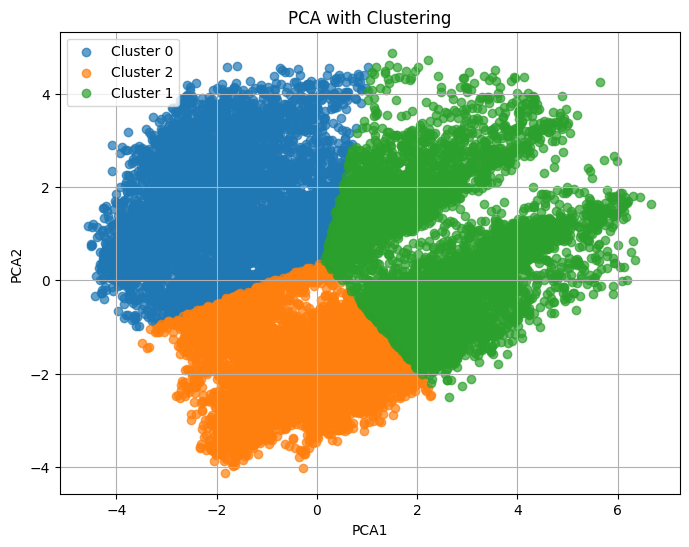

In [51]:
numeric_df = df.select_dtypes(include=['float64', 'int64'])

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_df)

pca = PCA(n_components=2)  # Reducing to two dimensions for visualization
pca_result = pca.fit_transform(scaled_data)

df_pca = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(pca_result)
df_pca['Cluster'] = kmeans_labels

plt.figure(figsize=(8, 6))
for cluster in df_pca['Cluster'].unique():
    subset = df_pca[df_pca['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', alpha=0.7)
plt.title('PCA with Clustering')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.grid()
plt.show()

In [52]:
df_combined = pd.concat([numeric_df, df_pca], axis=1)
cluster_characteristics = df_combined.groupby('Cluster').mean()

cluster_characteristics

,season,year,month,hour,week_num,holiday,work_day,weather_sit,temp,atemp,...,early_morning,morning,late_morning,afternoon,late_afternoon,early_evening,evening,late_evening,PCA1,PCA2
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1.309230,0.484012,2.831577,11.403161,10.612827,0.029433,0.677326,1.496185,0.335120,0.331047,...,0.150436,0.145167,0.138808,0.151163,0.031795,0.066315,0.084484,0.098656,-1.926276,1.574198
1,2.824397,0.588701,7.202051,14.893127,29.363620,0.023750,0.691796,1.263584,0.666279,0.625367,...,0.000000,0.125405,0.168586,0.312882,0.092839,0.168046,0.098777,0.033465,2.477395,0.542524
2,3.256609,0.442932,9.182523,8.727561,38.103372,0.032610,0.679436,1.505778,0.489071,0.470258,...,0.317872,0.108438,0.076144,0.054773,0.006174,0.024854,0.069970,0.115086,-0.501367,-1.848937


The characteristics of the three clusters:

Cluster 0:
• Lower activity in terms of casual and rental counts.
• Season is closer to early months (around season 1).
• Hour is mostly distributed around midday and in the early day range.
• Moderate work_day presence (close to average).
• This cluster has lower temperature, a-temp, and daylight hours.
• Contains more casual rentals during later evening hours.
• PCA indicates data that is less extreme in its separation (negative PCA1, higher PCA2 values).

Cluster 1:
• Peak activity for casual and registered rentals, concentrated mainly in favourable weather conditions.
• Associated primarily with season 2 and 3 (spring and summer), where temperatures are higher and preferable for rentals.
• Work-related characteristics, such as higher activity during mid-morning to late afternoon.
• Strong correlation to favorable temperatures.
• Higher casual and registered rental counts overall compared to other clusters.
• Strong positive values in PCA1; peak favourable conditions.

Cluster 2:
• Contains a mix of seasons but leans toward later months in the year (season 3-4).
• Hourly activities fall earlier in the day compared to cluster 1 but have more scattered activity than cluster 0.
• Slightly lower work_day influence compared to cluster 1.
• Characteristics suggest decline or less favourable conditions;  lower temperatures but higher humidity and windy conditions.
• PCA sees significant separation in PCA2 with highly negative values, indicating unfavourable scenarios for usage.

In [54]:
df_combined.groupby('Cluster')[['casual', 'registered']].mean()

,casual,registered
Cluster,,
0,14.982376,93.273438
1,82.909860,297.621986
2,12.148330,79.959158


The breakdown of casual and registered users in the clusters:  Cluster 1 has the highest activity for both casual and registered users, where clusters 0 and 2 have lower activity figures.

Cluster 0:
 • Average casual rentals: 14.98
 • Average registered rentals: 93.27

Cluster 1:
 • Average casual rentals: 82.91
 • Average registered rentals: 297.62

Cluster 2:
 • Average casual rentals: 12.15
 • Average registered rentals: 79.96

## Modeling.

In [56]:
df['hour_sin'] = np.sin(df.hour*(2. * np.pi / 24))
df['hour_cos'] = np.cos(df.hour*(2. * np.pi / 24))

One-hot-encoding some of the categorical values:  

In [58]:
transformer = make_column_transformer(
    (OneHotEncoder(), ['weekday', 'month', 'season', 'weather_sit']), remainder = 'passthrough')

Thinking about some strategies for additional grouping of the already-binned features here.  The daylight hours can all go together because there's a good spread of rentals between the hours of 0900 and 2000, especially in the months with longer days.  This would be a good opportunity to bin some "time of day" and workday (etc.) features and check for other correlations, with a view to collapsing any irrelevant features for the end model. 

Calculating daylight, time and day feature correlations: 

In [60]:
daylight_columns = ['s1_daylight_hrs', 's2_daylight_hrs', 's3_daylight_hrs', 's4_daylight_hrs']
daylight_corr = df[daylight_columns + ['casual', 'registered']].corr()

time_of_day_bins = ['midnight', 'early_morning', 'morning', 'late_morning', 'afternoon', 'late_afternoon', 'early_evening', 'evening', 'late_evening']
time_of_day_corr = df[time_of_day_bins + ['casual', 'registered']].corr()

workday_summary = df.groupby('work_day')[['casual', 'registered']].mean()
holiday_summary = df.groupby('holiday')[['casual', 'registered']].mean()

{
    'daylight_corr': daylight_corr[['casual', 'registered']],
    'time_of_day_corr': time_of_day_corr[['casual', 'registered']],
    'workday_summary': workday_summary,
    'holiday_summary': holiday_summary
}

{'daylight_corr':                    casual  registered
 s1_daylight_hrs -0.074626   -0.015212
 s2_daylight_hrs  0.294886    0.230371
 s3_daylight_hrs  0.306448    0.300449
 s4_daylight_hrs  0.139006    0.238208
 casual           1.000000    0.506618
 registered       0.506618    1.000000,
 'time_of_day_corr':                   casual  registered
 midnight             NaN         NaN
 early_morning  -0.298078   -0.371334
 morning        -0.111161    0.221422
 late_morning    0.172403   -0.000419
 afternoon       0.350294    0.108469
 late_afternoon  0.163927    0.322895
 early_evening   0.118184    0.319236
 evening        -0.021047    0.026255
 late_evening   -0.103960   -0.125728
 casual          1.000000    0.506618
 registered      0.506618    1.000000,
 'workday_summary':              casual  registered
 work_day                       
 0         57.441422  123.963910
 1         25.561315  167.646439,
 'holiday_summary':             casual  registered
 holiday                     

Here we see a low negative correlation between s1_daylight_hrs (spring) for both casual and registered users.  

1.  Daylight hour bins:  

• Summer and Autumn show the most reasonable correlations for casual users at 0.29 and 0.31, respectively.  Winter sees the third-strongest correlation at 0.14 for casual, and a seen earlier, a higher rate (0.24 here) for registered users in this season.  So I will combine s2 and s3_daylight_hrs due to their close correlations. 

2.  Time of day bins:  

• Early morning shows a negative correlation with both casual and registered users.

• Late afternoon and early evening have moderate positive correlations with registered users.

• Afternoon has the highest positive correlation with casual users, making this the most important bin of all. 

3.  Workday bins:

• On workdays, casual usage averages less than half of that on non-workdays. 

• On holidays, casual rentals are slightly higher, though registered users are lower.

So as well as combining summer and autumn as "combined_daylight_hrs", I will place the time of day bins with minimal relevance into a column named "low_usage".  Then I will combine afternoon and late_afternoon into an 'active_afternoon' bin / column.  

In [62]:
df['combined_daylight_hrs'] = df['s2_daylight_hrs'] + df['s3_daylight_hrs']
df['low_usage'] = df['midnight'] + df['early_morning']
df['active_afternoon'] = df['afternoon'] + df['late_afternoon']

y = df.casual

X = df.drop(['afternoon', 'late_afternoon', 's1_daylight_hrs', 's2_daylight_hrs', 's3_daylight_hrs', 's4_daylight_hrs', 
            'midnight', 'early_morning', 'casual', 'rental_count', 'hour'], axis=1, inplace=True)

,season,year,month,hour,week_num,holiday,weekday,work_day,weather_sit,temp,...,morning,late_morning,early_evening,evening,late_evening,hour_sin,hour_cos,combined_daylight_hrs,low_usage,active_afternoon
0,1,0,1,0,52,0,Saturday,0,1,0.24,...,0,0,0,0,0,0.000000,1.000000,0,0,0
1,1,0,1,1,52,0,Saturday,0,1,0.22,...,0,0,0,0,0,0.258819,0.965926,0,0,0
2,1,0,1,2,52,0,Saturday,0,1,0.22,...,0,0,0,0,0,0.500000,0.866025,0,0,0
3,1,0,1,3,52,0,Saturday,0,1,0.24,...,0,0,0,0,0,0.707107,0.707107,0,1,0
4,1,0,1,4,52,0,Saturday,0,1,0.24,...,0,0,0,0,0,0.866025,0.500000,0,1,0


In [64]:
transformed = transformer.fit_transform(X)
X = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 10,
    'min_child_weight': 5,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'random_state': 42
}

xgb_model_2 = XGBRegressor(**best_params)
xgb_model_2.fit(X_train, y_train)

xgb_model_2.fit(X_train, y_train)

xgb_r2 = xgb_model_2.score(X_test, y_test)
print(f"R2 score: {round(xgb_r2, 3)}")
y_pred = xgb_model_2.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_pred)
xgb_rmse = np.sqrt(xgb_mse)
print(f"RMSE: {round(xgb_rmse, 3)}")

R2 score: 0.946
RMSE: 11.168


Scatterplot of predicted values: 

In [66]:
fig = px.scatter(x=y_test, y=xgb_model_2.predict(X_test), labels={'x': 'Actual', 'y': 'Predicted'}, trendline="ols", trendline_color_override = "red")
fig.update_layout(title_text="Actual vs Predicted values for rentals by casual users with XGBoost", height=400)
fig.layout.title.x = 0.5
fig.show()

SHAP explainer:

100%|===================| 3462/3476 [03:30<00:00]       

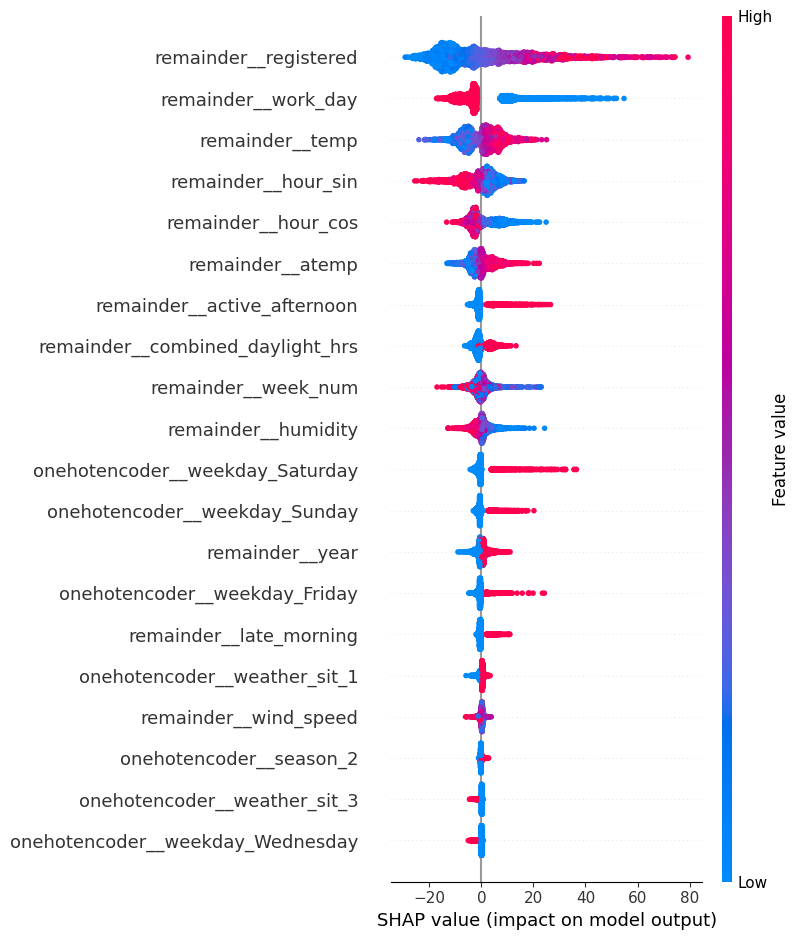

In [68]:
explainer = shap.Explainer(xgb_model_2, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

### Results.

The SHAP analysis reveals the top 10 influential features on the model's output and their average impact:

• 1:  registered (14.30): This feature, which represents the registered users, has the highest influence on predicting casual rentals. It likely captures indirect relationships or overlaps between casual and registered usage patterns.
• 2:  work_day (9.26): Whether or not it's a workday has a high impact on casual bike rentals. As seen so far in the EDA, casual rentals are generally higher during weekends and non-workdays.
• 3:  temp (5.55): Temperature has a strong positive influence on casual rental counts, as pleasant weather encourages leisure biking.
• 4:  hour_sin (4.92).  Hour sin & cos are the result of cyclical treatment so we will have to refer to the EDA for more in-depth information re: exact rental times.  Time on its own will be important because every rental has a time attached to it, although with the introduction of more variables such as day, month etc., the time variable on its own begins to hold a little less weight.  The pivot table in the EDA returns the times of the month for better insights into time ++ [other features].  
• 5:  hour_cos (4.30).
• 6:  a-temp (3.27): 'Feels-like' temperature has a notable effect on predicting rentals, as it combines temperature and perceived comfort.  This is a very informative nugget which begs further investigation (TBC). 
• 7:  active_afternoon (2.40): Active afternoon hours (afternoon + late_afternoon) obviously influence casual rentals since these times align with leisure activities and have had the benefit of further data binning, due to their importance / influence. 
• 8:  combined_daylight_hrs (2.34): Daylight availability during seasons plays a moderate role in determining rental counts.
• 9:  week_num (2.28): The week number in the year has some influence, potentially indicating seasonal effects or trends over time.
• 10: humidity (2.27): Humidity negatively affects casual rentals, as higher levels of humidity make cycling less comfortable.  

Saturday, Sunday and Friday are important features as also seen in the EDA. 

### Recommendations. 

It's doubtful that there exists great potential for flipping casual users, but there is some.  The overlap in casual vs. registered use witnessed here doesn't require much investigation and the resulting push for further registrations could be focussed in one or two small areas for maximum impact, such as long-term commuting (this is a hobby project so I won't go into a lot of detail here, but this is one instance that *pops* to me, personally).  

Alternatively, if this data were used to forecast conditions for both the placement or removal of bikes in certain sharing locations, there is plenty of information in the clusters, pivot tables and SHAP plot by which to make a few sound decisions.  Cheers. 